In [1]:
# Import Necessary Libraries
import numpy as np
import scipy.io

import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt
import itertools

import scipy.stats as stats
from scipy.spatial import distance as Distance

# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

%matplotlib inline

## import processing libs
from sklearn.decomposition import PCA

In [37]:
################################### HYPER-PARAMETERS TO TUNE #######################################################
np.random.seed(123456789)  # for reproducibility, set random seed
distances = Distance.cosine # define distance metric to use
num_time_windows = 10
low_freq_bands = [0, 1]
high_freq_bands = [3, 4, 5, 6]
freq_bands = np.arange(0,7,1)

freq_labels = ['delta', 'theta', 'alpha', 'beta', 'low gamma', 'high gamma', 'HFO']
# print freq_bands
# print [freq_labels[i] for i in freq_bands]

print 'low bands: ', [freq_labels[i] for i in low_freq_bands]
print 'high bands: ', [freq_labels[i] for i in high_freq_bands]
print "The length of the feature vector for each channel will be: ", num_time_windows*len(freq_bands), \
            ' total=', 96*num_time_windows*len(freq_bands)
def plotScree(sing_vals, eig_vals_ratio):
    # plot scree plot
    fig = plt.figure(figsize=(8,5))
    plt.plot(sing_vals, eig_vals_ratio, 'ro-', linewidth=2)
    plt.title('Scree Plot For Frequency Vector Features For All Channels')
    plt.xlabel('Principal Component')
    plt.ylabel('Eigenvalue')
    plt.axhline(0.9)
    leg = plt.legend(['Eigenvalues from PCA'], loc='best', borderpad=0.3, 
         shadow=False, markerscale=0.2)
    
def plotDescription(session, firstblock, secondblock):
    fig=plt.figure()
    axes = plt.gca()
    ymin, ymax = axes.get_ylim()
    xmin, xmax = axes.get_xlim()
    plt.text((xmax-xmin)/4.5, (ymax-ymin)/2, r'Session %s %scomparing %s and %s'%(session, '\n',firstblock, secondblock), fontsize=20)
    plt.title(session + ' across-block analysis')
    plt.grid(False)

def plotHistogramDistances(distances, session, firstblock, secondblock, wordpairtype):
    fig = plt.figure()
    ax = plt.gca()
    ax.grid(False)
    plt.hist(distances, color='k', lw=3)
    plt.xlabel('Cosine Similarity n='+str(len(distances)))
    plt.ylabel('Frequency Count')
    plt.title(wordpairtype + ' Within-block pairwise distances in ' + \
              session + ' with ' + firstblock + ' and ' + secondblock)
    plt.xlim([-1,1])
    plt.legend(r'n= %s'%(str(len(distances))))
    plt.tight_layout()

def find_same(wordpair, groups):
    # split wordpair and reverse
    wordsplit = wordpair.split('_')    
    try:
        sameword_index = groups.index(wordpair)
    except:
        sameword_index = -1
    return sameword_index

# functions for finding the different groups of word pairings
def find_reverse(wordpair, groups):
    # split wordpair and reverse
    wordsplit = wordpair.split('_')
    wordsplit.reverse()
    reverseword = '_'.join(wordsplit)
    # find index of reversed word index
    try:
        reverseword_index = groups.index(reverseword)
    except:
        reverseword_index = -1
    return reverseword_index
def find_different(wordpair, groups):
    # split wordpair and reverse
    wordsplit = wordpair.split('_')    
    differentword_index = []
    
    for idx, group in enumerate(groups):
        groupsplit = group.split('_')
        if not any(x in groupsplit for x in wordsplit):
            differentword_index.append(idx)
    
    # convert to single number if a list
    if len(differentword_index) == 1:
        differentword_index = differentword_index[0]
    return differentword_index

# check if group is in the list of names
def inGroup(group, names):
    for i in range(0, len(group)):
        if cmpT(group[i],names):
            return True
    return False

def cmpT(t1, t2): 
    return sorted(t1) == sorted(t2)

# Compute all pairwise distances between first_mat to second_mat
def computePairDistances(first_mat, second_mat):
    distance_list = []
    for idx in range(0, first_mat.shape[0]):
        distance_list.append([distances(x, first_mat[idx,:]) for x in second_mat])
    distance_list = 1.0 - np.ndarray.flatten(np.array(distance_list))
    return distance_list 

###### FIX REVERSE TO ADD THE OTHER WORD PAIR C/B != B/C in across blocks
def createWordGroups(firstwordpairs, secondwordpairs):
    diff_word_group = []
    reverse_word_group = []
    same_word_group = []
        
    # create same group pairs
    for idx, pair in enumerate(firstwordpairs):
        same_word_index = find_same(pair, secondwordpairs)
        reverse_word_index = find_reverse(pair, secondwordpairs)
        diff_word_index = find_different(pair, secondwordpairs)

        ## 01.1: Add these to an indice list for each word pairs
        # append to list groupings holding pairs of these word groupings
        if same_word_index != -1 and not inGroup(same_word_group, [pair, secondwordpairs[same_word_index]]):
            same_word_group.append([pair, secondwordpairs[same_word_index]])
        if reverse_word_index != -1 and not inGroup(reverse_word_group, [pair, secondwordpairs[reverse_word_index]]): 
            reverse_word_group.append([pair, secondwordpairs[reverse_word_index]])
        if diff_word_index != -1:
            if isinstance(diff_word_index, list): # if list, break it down and one pairing at a time
                for diffI in diff_word_index:     # loop through each different word index
                    if not inGroup(diff_word_group, [pair, secondwordpairs[diffI]]):
                        diff_word_group.append([pair, secondwordpairs[diffI]])
            else:
                diff_word_group.append([pair, secondwordpairs[diff_word_index]])
            
    return same_word_group, reverse_word_group, diff_word_group

def extractSubjSessionBlockData(subj, session, block):
    # file directory for a subj/session/block
    filedir = '../../condensed_data_' + subj + '/sessions_05122016/' + session + '/' + block
    wordpairs = os.listdir(filedir) 
    
    # initialize data dictionary with meta data
    data_dict = {}
    data_dict['meta'] = {'subject': subj,
                         'session': session,
                         'block': block}
    data_dict['data'] = {}
    for wordpair in wordpairs:    # loop thru all wordpairs
        wordpair_dir = filedir + '/' + wordpair
        all_channel_mats = os.listdir(wordpair_dir)
        
        data_dict['data'][wordpair] = {}
        for channel in all_channel_mats: # loop thru all channels
            chan_file = wordpair_dir + '/' + channel

            ## 00: load in data
            data = scipy.io.loadmat(chan_file)
            data = data['data']
            
            ## 01: get the time point for probeword on
            timeZero = data['timeZero'][0][0][0]
        
            ## 02: get the time point of vocalization
            vocalization = data['vocalization'][0][0][0]
        
            ## 03: Get Power Matrix
            power_matrix = data['powerMatZ'][0][0]
            
            chan = channel.split('_')[0]
            
            # convert channel data into a json dict
            data_dict['data'][wordpair][chan] = {'timeZero': timeZero,
                                          'timeVocalization':vocalization,
                                          'powerMat': power_matrix}
            
    return data_dict

def createPairsFeatureMat(pairs, firstblock_data, secondblock_data):
    feature_mat1 = np.array(()) # feature matrices for each word pair
    feature_mat2 = np.array(())

    # get pairs of words 
    firstpair = pairs[0] # from block i
    secondpair = pairs[1] # from block i+1

    ## loop through all channels and create feature vectors for every event
    for chan in channels:
        ## 01: extract channel data from blockdata dictionary
        first_probeOnTime = firstblock_data['data'][firstpair][str(chan)]['timeZero']
        first_vocalizationTime = firstblock_data['data'][firstpair][str(chan)]['timeVocalization']
        first_powerMat = firstblock_data['data'][firstpair][str(chan)]['powerMat']
        second_probeOnTime = secondblock_data['data'][secondpair][str(chan)]['timeZero']
        second_vocalizationTime = secondblock_data['data'][secondpair][str(chan)]['timeVocalization']
        second_powerMat = secondblock_data['data'][secondpair][str(chan)]['powerMat']

        ## 02: average across time and append frequency feature vector
        mat_buffer = []
        for i in range(0, len(first_vocalizationTime)):
            feature_vect = np.mean(first_powerMat[i,freq_bands,\
                                                  first_vocalizationTime[i]-num_time_windows:first_vocalizationTime[i]],axis=1)
            mat_buffer.append(np.ndarray.flatten(feature_vect))
        ## 03:append freq. feature vector per channel to each event
        if feature_mat1.size == 0:
            feature_mat1 = np.array(mat_buffer)
        else:
            feature_mat1 = np.append(feature_mat1, np.array(mat_buffer), axis=1)

        mat_buffer = []
        for i in range(0, len(second_vocalizationTime)):
            feature_vect = np.mean(second_powerMat[i,freq_bands,\
                                                   second_vocalizationTime[i]-num_time_windows:second_vocalizationTime[i]],axis=1)
            mat_buffer.append(np.ndarray.flatten(feature_vect))
        ## 03:append freq. feature vector per channel to each event
        if feature_mat2.size == 0:
            feature_mat2 = np.array(mat_buffer)
        else:
            feature_mat2 = np.append(feature_mat2, np.array(mat_buffer), axis=1)
    
    return feature_mat1, feature_mat2

low bands:  ['delta', 'theta']
high bands:  ['beta', 'low gamma', 'high gamma', 'HFO']
The length of the feature vector for each channel will be:  70  total= 6720


Analyzing session  session_1
{'session': 'session_1', 'block': 'BLOCK_0', 'subject': 'NIH034'}
{'session': 'session_1', 'block': 'BLOCK_1', 'subject': 'NIH034'}
(700,)
(2960,)


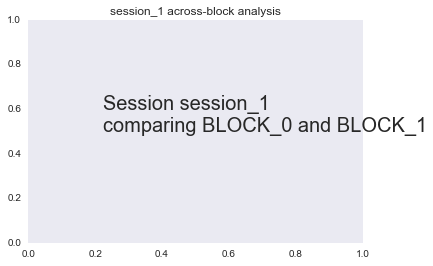

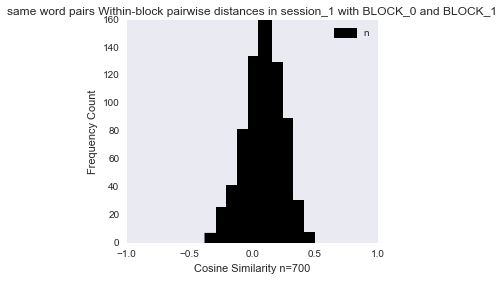

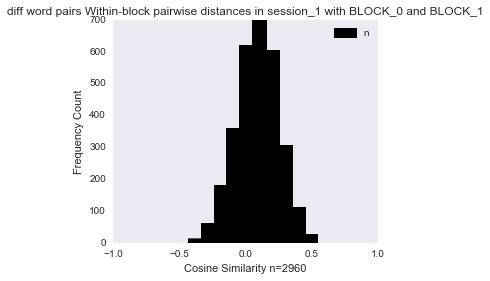

In [38]:
######## Get list of files (.mat) we want to work with ########
subj = 'NIH034'
filedir = '../../condensed_data_' + subj + '/sessions_05122016/'
sessions = os.listdir(filedir)
sessions = sessions[2:]
num_chans = 96
debug_on = 1

# loop through each session
for session in sessions:
    print "Analyzing session ", session
    sessiondir = filedir + session
    
    # get all blocks for this session
    blocks = os.listdir(sessiondir)

    # loop through each block two at a time, analyze
    for i in range(0, len(blocks)-1):
        # get the i'th and i+1'th block
        firstblock = blocks[i]
        secondblock = blocks[i+1]
        firstblock_dir = sessiondir + '/' + firstblock
        secondblock_dir = sessiondir + '/' + secondblock
        
        # in each block, get list of word pairs from first and second block
        firstwordpairs = os.listdir(firstblock_dir)
        secondwordpairs = os.listdir(secondblock_dir)
    
        ## 01: Create WordPair Groups
        same_word_group, reverse_word_group, diff_word_group = createWordGroups(firstwordpairs, secondwordpairs)
        
        plotDescription(session, firstblock, secondblock)
        
        ## 02: extract sessionblockdata dictionary for all channels
        firstblock_data = extractSubjSessionBlockData(subj, session, firstblock)
        secondblock_data = extractSubjSessionBlockData(subj, session, secondblock)
        channels = np.arange(1, num_chans+1, 1)
        
        # initialize arrays to hold the distance measures across blocks
        same_pair_distances = np.array(())
        diff_pair_distances = np.array(())
        
        for pairs in same_word_group:
            feature_mat1, feature_mat2 = createPairsFeatureMat(pairs, firstblock_data, secondblock_data)
        
            ## 04: Feature Matrices Into PCA, or keep the same
            # i) subtract mean of other block
            # ii) concatenate along axis=0 and PCA
            # iii) split up matrix and cosine similarity
            if same_pair_distances.size == 0:
                same_pair_distances = computePairDistances(feature_mat1, feature_mat2)
            else:
                same_pair_distances = np.append(same_pair_distances, computePairDistances(feature_mat1, feature_mat2))
        for pairs in diff_word_group:
            feature_mat1, feature_mat2 = createPairsFeatureMat(pairs, firstblock_data, secondblock_data)
        
            if diff_pair_distances.size == 0:
                diff_pair_distances = computePairDistances(feature_mat1, feature_mat2)
            else:
                diff_pair_distances = np.append(diff_pair_distances, computePairDistances(feature_mat1, feature_mat2))
            
        if debug_on:
            print firstblock_data['meta']
            print secondblock_data['meta']
            print same_pair_distances.shape
            print diff_pair_distances.shape
            debug_on = False
        
        ##### 01: Plot Histogram of Cosine Similarities
        plotHistogramDistances(same_pair_distances, session, firstblock, secondblock, 'same word pairs')
        plotHistogramDistances(diff_pair_distances, session, firstblock, secondblock, 'diff word pairs')
        
        
        break
    break
        


# Adding PCA Dimensionality Reduction

Analyzing session  session_1
{'session': 'session_1', 'block': 'BLOCK_0', 'subject': 'NIH034'}
{'session': 'session_1', 'block': 'BLOCK_1', 'subject': 'NIH034'}
(1480,)
(1480,)
On block:  BLOCK_0  and  BLOCK_1  using t-test
Same avg +/- std: -0.018686  +/- 0.003
Different avg +/- std: -0.007408  +/- 0.004
Same vs. Same comparison: 0.274713
Same vs. Different Comparison: 0.022478 

On block:  BLOCK_1  and  BLOCK_2  using t-test
Same avg +/- std: -0.010156  +/- 0.003
Different avg +/- std: -0.001865  +/- 0.003
Same vs. Same comparison: 0.963530
Same vs. Different Comparison: 0.083771 

On block:  BLOCK_2  and  BLOCK_3  using t-test
Same avg +/- std: -0.012527  +/- 0.003
Different avg +/- std: -0.014881  +/- 0.003
Same vs. Same comparison: 0.850696
Same vs. Different Comparison: 0.626470 

On block:  BLOCK_3  and  BLOCK_4  using t-test
Same avg +/- std: -0.009623  +/- 0.004
Different avg +/- std: -0.007466  +/- 0.003
Same vs. Same comparison: 0.681556
Same vs. Different Comparison: 0.6513

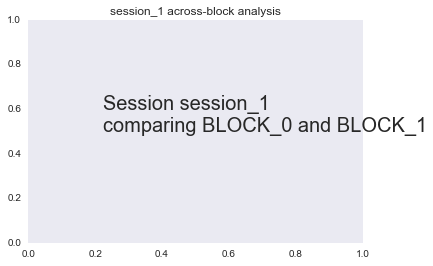

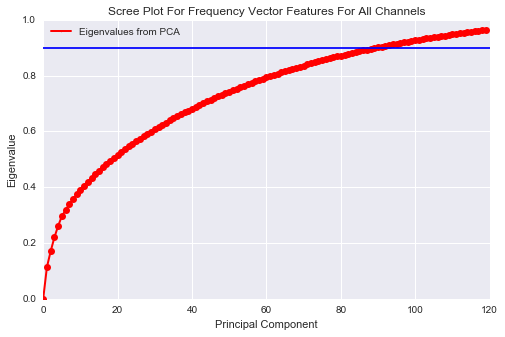

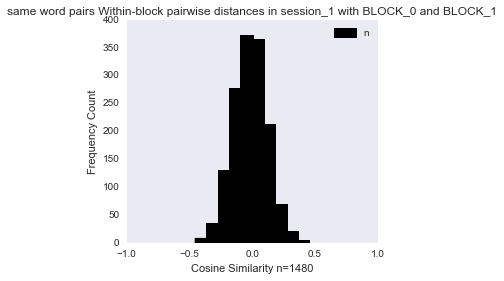

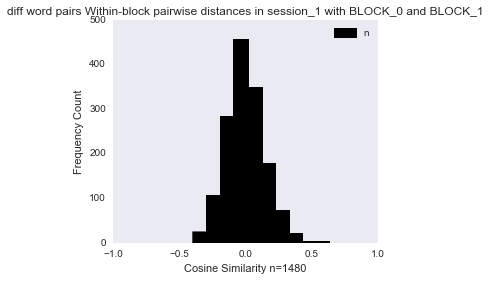

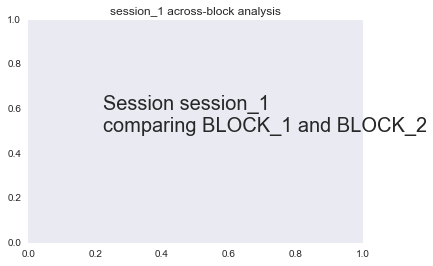

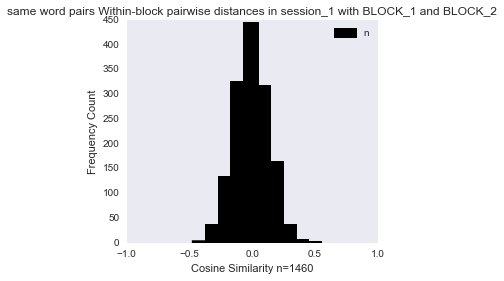

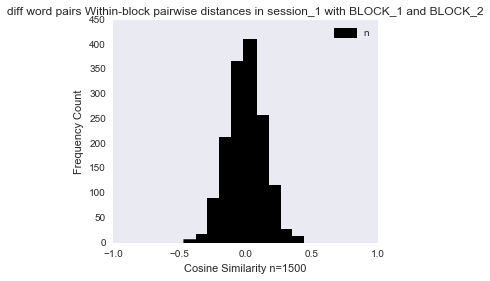

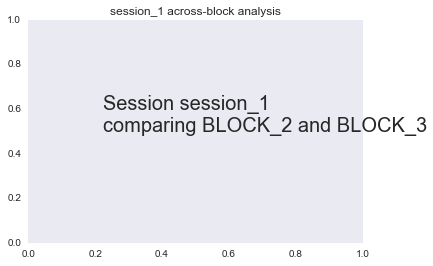

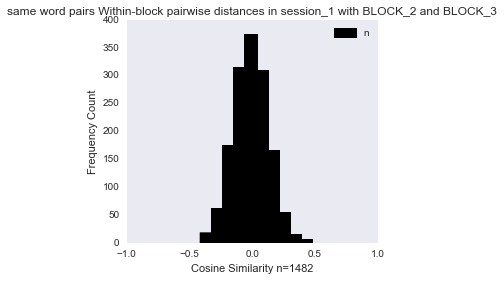

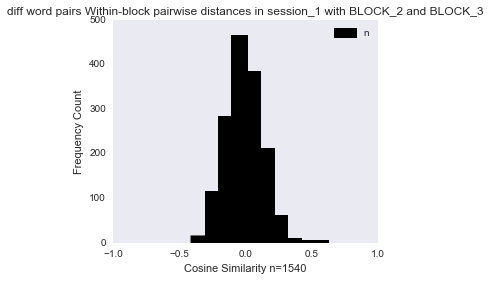

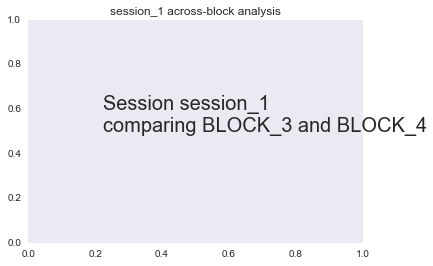

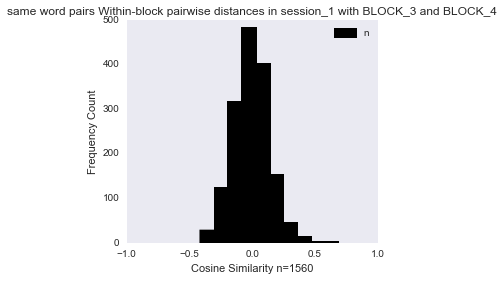

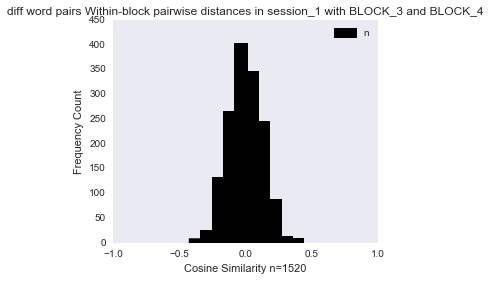

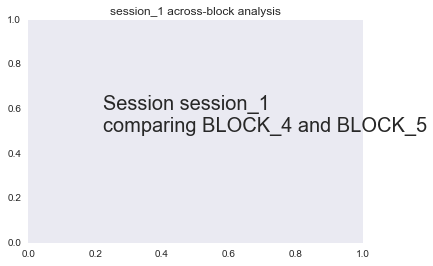

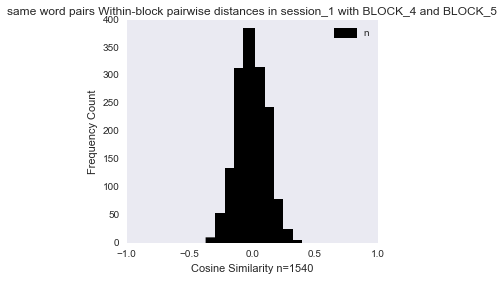

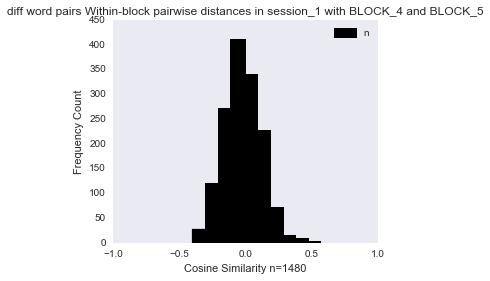

In [51]:
######## Get list of files (.mat) we want to work with ########
subj = 'NIH034'
filedir = '../../condensed_data_' + subj + '/sessions_05122016/'
sessions = os.listdir(filedir)
sessions = sessions[2:]
num_chans = 96
debug_on = 1

# loop through each session
for session in sessions:
    print "Analyzing session ", session
    sessiondir = filedir + session
    
    # get all blocks for this session
    blocks = os.listdir(sessiondir)

    # loop through each block two at a time, analyze
    for i in range(0, len(blocks)-1):
        # get the i'th and i+1'th block
        firstblock = blocks[i]
        secondblock = blocks[i+1]
        firstblock_dir = sessiondir + '/' + firstblock
        secondblock_dir = sessiondir + '/' + secondblock
        
        # in each block, get list of word pairs from first and second block
        firstwordpairs = os.listdir(firstblock_dir)
        secondwordpairs = os.listdir(secondblock_dir)
    
        ## 01: Create WordPair Groups
        same_word_group, reverse_word_group, diff_word_group = createWordGroups(firstwordpairs, secondwordpairs)
        
        plotDescription(session, firstblock, secondblock)
        
        ## 02: extract sessionblockdata dictionary for all channels
        firstblock_data = extractSubjSessionBlockData(subj, session, firstblock)
        secondblock_data = extractSubjSessionBlockData(subj, session, secondblock)
        channels = np.arange(1, num_chans+1, 1)
        
        # initialize arrays to hold the distance measures across blocks
        same_pair_distances = np.array(())
        diff_pair_distances = np.array(())
        
        feature_mat = np.array(())
        feature_classes = []
        for pairs in same_word_group:
            feature_mat1, feature_mat2 = createPairsFeatureMat(pairs, firstblock_data, secondblock_data)
            
            ## 04: Feature Matrices Into PCA, or keep the same
            # i) subtract mean of other block
            # ii) concatenate along axis=0 and PCA
            # iii) split up matrix and cosine similarity
#             feature_mat1 = feature_mat1 - np.mean(feature_mat2, axis=0)
#             feature_mat2 = feature_mat2 - np.mean(feature_mat1, axis=0)
            if feature_mat.size == 0:
                feature_mat = np.append(feature_mat1, feature_mat2, axis=0)
            else:
                feature_mat = np.append(feature_mat, feature_mat1, axis=0)
                feature_mat = np.append(feature_mat, feature_mat2, axis=0)
               
            # keep a count of the events for the same (first 8 are same pairs)
            if len(feature_classes) == 0:
                feature_classes.append(feature_mat1.shape[0])
                feature_classes.append(feature_classes[len(feature_classes)-1] + feature_mat2.shape[0])
            else:
                feature_classes.append(feature_classes[len(feature_classes)-1] + feature_mat1.shape[0])
                feature_classes.append(feature_classes[len(feature_classes)-1] + feature_mat2.shape[0])
            
        for pairs in diff_word_group:
            feature_mat1, feature_mat2 = createPairsFeatureMat(pairs, firstblock_data, secondblock_data)
            
            ## 04: Feature Matrices Into PCA, or keep the same
            # i) subtract mean of other block
            # ii) concatenate along axis=0 and PCA
            # iii) split up matrix and cosine similarity
#             feature_mat1 = feature_mat1 - np.mean(feature_mat2, axis=0)
#             feature_mat2 = feature_mat2 - np.mean(feature_mat1, axis=0)

            # append to the general feature matrix
            feature_mat = np.append(feature_mat, feature_mat1, axis=0)
            feature_mat = np.append(feature_mat, feature_mat2, axis=0)   
            
            # keep a count of the events for the diff (second 8 are diff pairs)
            feature_classes.append(feature_classes[len(feature_classes)-1] + feature_mat1.shape[0])
            feature_classes.append(feature_classes[len(feature_classes)-1] + feature_mat2.shape[0])
        
        ## PERFORM PCA
        num_comp = 120
        sklearn_pca = PCA(n_components=num_comp)
        sklearn_transf = sklearn_pca.fit_transform(feature_mat)
        sklearn_variance_explained = sklearn_pca.explained_variance_ratio_
        
        # get singular values and their explained variance
        sing_vals = np.arange(num_comp)
        eig_vals_ratio = [sum(sklearn_variance_explained[0:i]) for i in range(0,len(sklearn_variance_explained))]
        
        # loop through same pair events
        for iClass in range(0, 8, 2):
            if same_pair_distances.size == 0:
                same_pair_distances = computePairDistances(sklearn_transf[0:feature_classes[iClass], :],sklearn_transf[feature_classes[iClass]:feature_classes[iClass+1], :])
            else:
                currentPairDistances = computePairDistances(sklearn_transf[feature_classes[iClass-1]:feature_classes[iClass], :], sklearn_transf[feature_classes[iClass]:feature_classes[iClass+1], :])
                same_pair_distances = np.append(same_pair_distances, currentPairDistances)
        # loop through diff pair events
        for iClass in range(8, 16, 2):
            currentPairDistances = computePairDistances(sklearn_transf[feature_classes[iClass-1]:feature_classes[iClass], :], sklearn_transf[feature_classes[iClass]:feature_classes[iClass+1], :])
                
            if diff_pair_distances.size == 0:
                diff_pair_distances = currentPairDistances
            else:
                diff_pair_distances = np.append(diff_pair_distances, currentPairDistances)
                                                                        
        if debug_on:
            print firstblock_data['meta']
            print secondblock_data['meta']
            print same_pair_distances.shape
            print diff_pair_distances.shape
            plotScree(sing_vals, eig_vals_ratio)
            debug_on = False
        
        ##### 01: Plot Histogram of Cosine Similarities
        plotHistogramDistances(same_pair_distances, session, firstblock, secondblock, 'same word pairs')
        plotHistogramDistances(diff_pair_distances, session, firstblock, secondblock, 'diff word pairs')
        
        ##### RUN STATS COMPARISONS ON SAME VS. REVERSE, SAME VS. DIFF, 
        random_subset = np.random.choice(range(same_pair_distances.shape[0]), size=len(same_pair_distances)/2, replace=False)
        random_subset2 = list(set(np.arange(0, len(same_pair_distances))) - set(random_subset))
        same_X = same_pair_distances[random_subset]
        same_Y = same_pair_distances[random_subset2]
        
        # sub-sample the diff_word_distances if using ks_test
#         stat, same_p_val = stats.ks_2samp(same_X, same_Y)
#         stat, diff_p_val = stats.ks_2samp(same_word_distances, diff_word_distances)
           
        stat, same_p_val = stats.ttest_ind(same_X, same_Y)
        stat, diff_p_val = stats.ttest_ind(same_pair_distances, diff_pair_distances)
        
        print "On block: ", firstblock, " and ", secondblock, " using t-test"
        print "Same avg +/- std: %0.6f" %np.mean(same_pair_distances), ' +/- %0.3f' %stats.sem(same_pair_distances)
        print "Different avg +/- std: %0.6f" %np.mean(diff_pair_distances), ' +/- %0.3f' %stats.sem(diff_pair_distances)
        print "Same vs. Same comparison: %0.6f" %same_p_val
        print "Same vs. Different Comparison: %0.6f" %diff_p_val, "\n"
        
#         break
    break

In [43]:
print eig_vals_ratio[len(eig_vals_ratio)-1]

0.968000139938
